# LSTM - enhanced deep Koopman 

## NeuroMANCER and Dependencies

In [ ]:
import copy
import os
import sys
import time as tim

import numpy as np
import torch
import torch.nn as nn
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.modules import blocks
from neuromancer.problem import Problem
from neuromancer.slim import slim
from neuromancer.system import Node, System
from neuromancer.trainer import Trainer

sys.path.append(os.path.abspath(".."))
from src.datasets import get_data_loaders, simulate_two_tank
from src.plot import plot_results

%load_ext autoreload
%autoreload 2

seed = 0
torch.manual_seed(seed)

## Generate trajectories from ODE system 

In [3]:
delay = 20
n_samples = 20000

In [4]:
model, (train_data, dev_data, test_data) = simulate_two_tank(
    n_samples, n_sequences=3, delay=delay, noise_variance=0.1, seed=seed
)

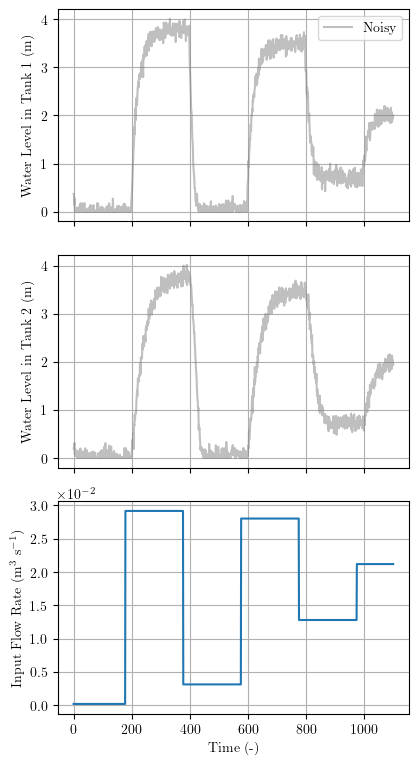

In [5]:
fig = plot_results(
    train_data["U"][:1100],
    {"Noisy": train_data["Y"][:1100]},
)

## Create training data of sampled trajectories


In [6]:
nsteps = 80  # number of prediction horizon steps in the loss function
bs = 100  # minibatching batch size
time = 80  # number of lookback window as input to lstm
train_loader, dev_loader, test_loader = get_data_loaders(
    model,
    {"train": train_data, "dev": dev_data, "test": test_data},
    n_samples,
    nsteps,
    time,
    bs,
)

In [7]:
max_length = float("-inf")
min_length = float("inf")

for batch in train_loader:
    # Assuming each batch contains input tensors
    # You can modify this based on your data structure

    for key, tensor in batch.items():
        # Get the length of the tensor
        try:
            length = tensor.shape[
                0
            ]  # Assuming tensor is of shape (length, ...)

            # Update max_length and min_length
            max_length = max(max_length, length)
            min_length = min(min_length, length)
        except:
            pass

print("Longest tensor length:", max_length)
print("Shortest tensor length:", min_length)

Longest tensor length: 100
Shortest tensor length: 49


## Deep Koopman model in Neuromancer

Here we construct a discrete-time encoder-decoder Koopman model with control:   

Encoder: $${x}_{k} = f_y(y_k) +f_u(u_k)$$ 
Koopman: $${x}_{k+1} = K(x_k)$$ 
Decoder: $$\hat{y}_{k+1} = f_y^{-1}(x_{k+1})$$  

In [8]:
# model parameters
ny = model.ny
nx = model.nx
nu = model.nu
nx_koopman = 40
n_hidden = 60
n_layers = 2
lstm_features = 8

**LSTM + Encoder and Decoder networks** 

In [9]:
f_yu = blocks.LSTMBlock(ny + nu, lstm_features)


def f_yuT(data):
    s = data.shape
    res = f_yu(data.reshape(s[0] * nsteps, time, ny + nu))
    return res.reshape(s[0], nsteps, lstm_features)


extract_time_features = Node(
    f_yuT, ["timeYU"], ["time_enc"], name="extract_time_features"
)

extract_time_features_0 = Node(
    f_yu, ["timeYU0"], ["time_enc0"], name="extract_time_features_0"
)

In [10]:
def stack(a, b):
    return torch.cat((a, b), dim=-1)

In [11]:
# instantiate output encoder neural net f_y
f_y = blocks.MLP(
    ny,
    nx_koopman,
    bias=True,
    linear_map=torch.nn.Linear,
    nonlin=torch.nn.ELU,
    hsizes=n_layers * [n_hidden],
)
f_y_lstm = blocks.MLP(
    ny + lstm_features,
    nx_koopman,
    bias=True,
    linear_map=torch.nn.Linear,
    nonlin=torch.nn.ELU,
    hsizes=n_layers * [n_hidden],
)

stack_Y0 = Node(stack, ["Y0", "time_enc0"], ["Y0_te"], name="stack_Y0")
stack_Y = Node(stack, ["Y", "time_enc"], ["Y_te"], name="stack_Y")
# initial condition encoder
encode_Y0 = Node(f_y, ["Y0"], ["x"], name="encoder_Y0")
# observed trajectory encoder
encode_Y = Node(f_y, ["Y"], ["x_latent"], name="encoder_Y")
# initial condition encoder
encode_Y0_lstm = Node(f_y_lstm, ["Y0_te"], ["x"], name="encoder_Y0")
# observed trajectory encoder
encode_Y_lstm = Node(f_y_lstm, ["Y_te"], ["x_latent"], name="encoder_Y")

In [12]:
# matrice B
K_B = torch.nn.Linear(nu, nx_koopman, bias=False)
encode_U = Node(K_B, ["U"], ["u_real"], name="encoder_U")

In [13]:
# instantiate state decoder neural net f_y_inv
f_y_inv = blocks.MLP(
    nx_koopman,
    ny,
    bias=True,
    linear_map=torch.nn.Linear,
    nonlin=torch.nn.ELU,
    hsizes=n_layers * [n_hidden],
)
# predicted trajectory decoder
decode_y = Node(f_y_inv, ["x"], ["yhat"], name="decoder_y")

In [14]:
# instantiate Koopman operator matrix
stable = True  # if True then provably stable Koopman operator
if stable:
    # SVD factorized Koopman operator with bounded eigenvalues: sigma_min <= \lambda_i <= sigma_max
    K = slim.linear.SVDLinear(
        nx_koopman, nx_koopman, sigma_min=0.01, sigma_max=1.0, bias=False
    )
    # SVD penalty variable
    K_reg_error = variable(K.reg_error())
    # SVD penalty loss term
    K_reg_loss = 1.0 * (K_reg_error == 0.0)
    K_reg_loss.name = "SVD_loss"
else:
    # linear Koopman operator without guaranteed stability
    K = torch.nn.Linear(nx_koopman, nx_koopman, bias=False)

In [15]:
class Koopman_control(nn.Module):
    """
    Baseline class for Koopman control model
    Implements discrete-time dynamical system:
        x_k+1 = K (x_k + u_k)
    with variables:
        x_k - latent states
        u_k - latent control inputs
    """

    def __init__(self, K):
        super().__init__()
        self.K = K

    def forward(self, x, u):
        """
        :param x: (torch.Tensor, shape=[batchsize, nx])
        :param u: (torch.Tensor, shape=[batchsize, nu])
        :return: (torch.Tensor, shape=[batchsize, nx])
        """
        x = self.K(x) + u
        return x

In [16]:
# symbolic Koopman model with control inputs
Koopman = Node(Koopman_control(K), ["x", "u_real"], ["x"], name="K")

# latent Koopmann rollout
dynamics_model = System([Koopman], name="Koopman", nsteps=nsteps)

## Define Koopman system identification loss function terms

Here we define loss function terms to fit the encoded-decoder Koopman parameters $\theta$ from given time-series data.
The loss function terms follow the implementation as given in the reference [[2]](https://www.nature.com/articles/s41467-018-07210-0). 

**Output trajectory prediction loss:**  
$$\ell_y = \sum_{k=1}^{N} Q_y||y^i_{k+1} - \hat{y}^i_{k+1}||_2^2$$ 
**One step output prediction loss:**  
$$\ell_{y_1} = Q_{y_1}||y^i_2 - \hat{y}^i_2||_2^2$$ 

where $\hat{y}^i_{k+1} = \phi^{-1}_{\theta_3}(K^k_{\theta_2}(\phi_{\theta_1}(y^i_1))) $, 
and $N$ is defining length of the rollout (prediction) horizon.  

**Latent trajectory prediction loss:**  
$$\ell_{\text{lin}} = \sum_{k=1}^{N}  Q_x||\phi_{\theta_1}(y_{k+1}^i) - K^k\phi_{\theta_1}(y_1^i)||_2^2$$ 


In [17]:
# variables
Y = variable("Y")  # observed
yhat = variable("yhat")  # predicted output
x_latent = variable(
    "x_latent"
)  # encoded output trajectory in the latent space
# u_latent = variable('u_latent')  # encoded input trajectory in the latent space
u_real = variable("u_real")  # real input trajectory
x = variable("x")  # Koopman latent space trajectory

# xu_latent = x_latent + u_latent  # latent state trajectory

# output trajectory tracking loss
y_loss = 10.0 * (yhat[:, 1:-1, :] == Y[:, 1:, :]) ^ 2
y_loss.name = "y_loss"

# one-step tracking loss
onestep_loss = 1.0 * (yhat[:, 1, :] == Y[:, 1, :]) ^ 2
onestep_loss.name = "onestep_loss"

# latent trajectory tracking loss
x_loss = 1.0 * (x[:, 1:-1, :] == x_latent[:, 1:, :]) ^ 2
x_loss.name = "x_loss"

## Construct System ID learning problem

Given the training dataset $\hat{X} = [\hat{x}^i_0, ..., \hat{x}^i_{N}]$ we want to solve the following problem:
 
$$
\begin{align}
&\underset{\theta}{\text{minimize}}     && \sum_{i=1}^m \Big( \ell_{y} + \ell_{y_1}  +\ell_{\text{lin}} + \ell_{\text{recon}} + \ell_{\text{stable}} \Big) \\
&\text{subject to}    && \hat{y}^i_{k+1} = \phi^{-1}_{\theta_3}(K^k_{\theta_2}(\phi_{\theta_1}(y_1^i))) \\
\end{align}
$$  

In [20]:
# aggregate list of objective terms and constraints
objectives = [y_loss, x_loss, onestep_loss]

if stable:
    objectives.append(K_reg_loss)

# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints=[])

In [21]:
# construct constrained optimization problem
problems = {
    "LSTM DKO": Problem(
        [
            extract_time_features,
            extract_time_features_0,
            stack_Y0,
            stack_Y,
            encode_Y0_lstm,
            encode_Y_lstm,
            copy.deepcopy(encode_U),
            copy.deepcopy(dynamics_model),
            copy.deepcopy(decode_y),
        ],
        loss,
    ),
    "DKO": Problem(
        [
            encode_Y0,
            encode_Y,
            copy.deepcopy(encode_U),
            copy.deepcopy(dynamics_model),
            copy.deepcopy(decode_y),
        ],
        loss,
    ),
}

## Solve the problem

We fit the unknown NODE parameters $\theta$ using stochastic gradient descent.

Long running code approx 25minutes

In [22]:
for name, problem in problems.items():
    # Initialize
    optimizer = torch.optim.Adam(problem.parameters(), lr=0.001)

    trainer = Trainer(
        problem,
        train_loader,
        dev_loader,
        test_loader,
        optimizer,
        patience=200,
        warmup=100,
        epochs=1500,
        eval_metric="dev_loss",
        train_metric="train_loss",
        dev_metric="dev_loss",
        test_metric="dev_loss",
    )
    # Train
    start = tim.time()
    best_model = trainer.train()
    problem.load_state_dict(best_model)
    end = tim.time()
    print(f"Elapsed time training: {end - start:.0f} s")

    # Save best model
    torch.save(best_model, f"results/{name}.pth")

epoch: 0  train_loss: 17.568288803100586
epoch: 1  train_loss: 14.2902250289917
epoch: 2  train_loss: 10.561735153198242
epoch: 3  train_loss: 8.843902587890625
epoch: 4  train_loss: 9.387110710144043
epoch: 5  train_loss: 8.395212173461914
epoch: 6  train_loss: 8.173148155212402
epoch: 7  train_loss: 7.758451461791992
epoch: 8  train_loss: 7.053133010864258
epoch: 9  train_loss: 6.912092685699463
epoch: 10  train_loss: 6.804290294647217
epoch: 11  train_loss: 7.047501087188721
epoch: 12  train_loss: 6.945437908172607
epoch: 13  train_loss: 6.7012553215026855
epoch: 14  train_loss: 6.82935905456543
epoch: 15  train_loss: 6.673547267913818
epoch: 16  train_loss: 6.821497440338135
epoch: 17  train_loss: 6.501437664031982
epoch: 18  train_loss: 6.336409091949463
epoch: 19  train_loss: 6.600865840911865
epoch: 20  train_loss: 6.215622425079346
epoch: 21  train_loss: 5.993391513824463
epoch: 22  train_loss: 5.649936199188232
epoch: 23  train_loss: 5.639110565185547
epoch: 24  train_loss: 6.

## System Identification results

In [38]:
# update the rollout length based on the test data
# TODO: find out why does DeReK with LSTM crash with longer periods
n_test = 5600  # test_data["Y"].shape[0]
test_datadict = test_loader.dataset.datadict

In [ ]:
def denormalize(x, mean, std):
    return x * std + mean


mean_x = model.stats["Y"]["mean"]
std_x = model.stats["Y"]["std"]
mean_u = model.stats["U"]["mean"]
std_u = model.stats["U"]["std"]

Y_tests_pred = {}

for name, problem in problems.items():
    if name == "DeReK":
        res2 = problem.nodes[0]({"Y0": test_datadict["Y0"][0:1, :, :]})
    else:
        res = problem.nodes[1]({
            "timeYU0": test_datadict["timeYU0"][0:1, :, :]
        })
        res1 = problem.nodes[2]({
            "time_enc0": res["time_enc0"],
            "Y0": test_datadict["Y0"][0:1, :, :],
        })
        res2 = problem.nodes[4](res1)
    # resU = problems["DeReK"].nodes[6]({"U": test_datadict["U"].reshape(1, n_test - time, 1)})
    resU = problems["DeReK"].nodes[-3]({
        "U": test_datadict["U"][: n_test // time, :, :].reshape(1, n_test, 1)
    })
    problems["DeReK"].nodes[-2].nsteps = n_test - time
    res3 = problems["DeReK"].nodes[-2]({
        "x": res2["x"],
        "u_real": resU["u_real"],
    })
    res4 = problems["DeReK"].nodes[-1](res3)

    pred_traj = res4["yhat"][:, :-1, :].detach().numpy().reshape(-1, nx)

    Y_tests_pred[name] = denormalize(pred_traj, mean_x, std_x)

In [43]:
true_traj = (
    test_datadict["Y"][: n_test // time, :, :].detach().numpy().reshape(-1, nx)
)
input_traj = (
    test_datadict["U"][: n_test // time, :, :]
    .reshape(1, n_test, 1)
    .detach()
    .numpy()
    .reshape(-1, nu)
)

In [44]:
import pickle

with open("data/y_NNs.pkl", "wb") as fp:
    pickle.dump(Y_tests_pred, fp)

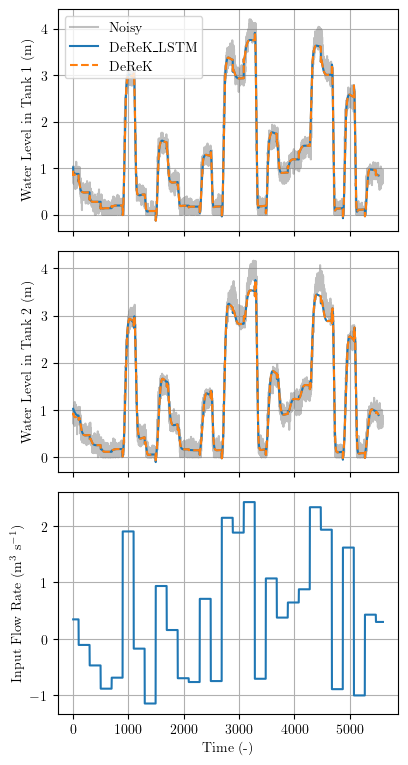

In [45]:
fig = plot_results(
    input_traj,
    {"Noisy": denormalize(true_traj, mean_x, std_x), **Y_tests_pred},
)

In [47]:
# save A and B matrices, where A = K.effective_W() and B = K_B.weight
A = K.effective_W().detach().numpy()
B = K_B.weight.detach().numpy()

np.save("results/A_DeReK_noise.npy", A)
np.save("results/B_DeReK_noise.npy", B)

In [55]:
# compute Koopman eigenvalues and eigenvectors
if stable:
    eig, eig_vec = torch.linalg.eig(K.effective_W())
else:
    eig, eig_vec = torch.linalg.eig(K.weight)
# Koopman eigenvalues real and imaginary parts
eig = eig.detach().numpy()
eig = eig[np.argsort(eig)[::-1]]

In [ ]:
np.save("results/eig_derek.npy", eig)